In [153]:
%reload_ext autoreload

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader

sys.path.append("/home/wangbrh/BrainProject/")
sys.path.append("/home/wangbrh/BrainProject/results")
sys.path.append("/home/wangbrh/BrainProject/utils")
sys.path.append("/home/wangbrh/BrainProject/utils/models")
sys.path.append("/home/wangbrh/BrainProject/datasets/forrest/movie_snapshots")

from utils import Datasets, plotUtils, loadUtils, featureUtils, evalUtils, models, extractRunFrames, Paths
from plotUtils import peekImageFolderDS, sampleAE, plotCompareFeatures, showAnat
from loadUtils import loadModel, loadFMRI, loadFeatures, loadPixelFeatures
from fitUtils import fitAE, fitFeatureModel, featureNetCrossVal
from featureUtils import generateAllFeatures, convolveFeatures
from evalUtils import correlateFeature, evaluateFeatureDataset
from Datasets import SingleDirDataset, FeatureDataset
from models import SimpleConvAE, FeatureNet

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


True True True True True True True True True 

In [2]:
current_model = 'SimpleConvAE'

In [3]:
torch.cuda.is_available()

True

# Train Autoencoder

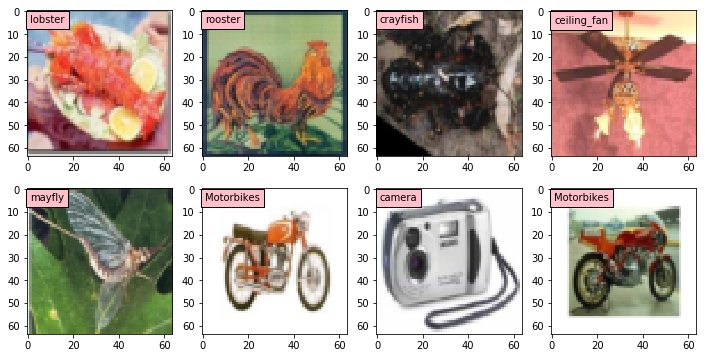

In [27]:
image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
])
traindataset = torchvision.datasets.ImageFolder(
    root=Paths.objects_dataset_path,
    transform=image_transforms
)
trainloader = DataLoader(traindataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)

peekImageFolderDS(traindataset)

In [28]:
import torch.nn as nn
from torchsummary import summary

class SimpleConvAESmall(nn.Module):
    def __init__(self):
        super().__init__()

        # in: b, 3, 64, 64
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 6, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(6),

            nn.MaxPool2d(2, stride=2, return_indices=True),
        )

        self.unpool = nn.MaxUnpool2d(2, stride=2, padding=0)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(6, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        encoded, indices = self.encoder(x)
        out = self.unpool(encoded, indices)
        out = self.decoder(out)
        return (out, encoded)

simpleAE = SimpleConvAESmall().cuda()
summary(simpleAE, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
       BatchNorm2d-3           [-1, 16, 64, 64]              32
            Conv2d-4            [-1, 6, 64, 64]             870
              ReLU-5            [-1, 6, 64, 64]               0
       BatchNorm2d-6            [-1, 6, 64, 64]              12
         MaxPool2d-7  [[-1, 6, 32, 32], [-1, 6, 32, 32]]               0
       MaxUnpool2d-8            [-1, 6, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 64, 64]             880
             ReLU-10           [-1, 16, 64, 64]               0
  ConvTranspose2d-11            [-1, 3, 64, 64]             435
             ReLU-12            [-1, 3, 64, 64]               0
Total params: 2,677
Trainable params: 2,677
Non-trainable params: 0
--------------------------

In [29]:
from torch import nn, optim

# aeNet = SimpleConvAE().cuda()
aeNet = SimpleConvAESmall().cuda()
criterion = nn.MSELoss()
optimizer = optim.SGD(aeNet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
fitAE(aeNet, criterion, optimizer, trainloader, epochs=100)

In [30]:
aeNet(traindataset.__getitem__(0)[0].unsqueeze(0).cuda())[1].view(1, -1).shape[1]

6144

In [31]:
# Save to 'model.pth'
torch.save({
            'model_state_dict': aeNet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, './savedModels/SimpleConvAESmall.pth')

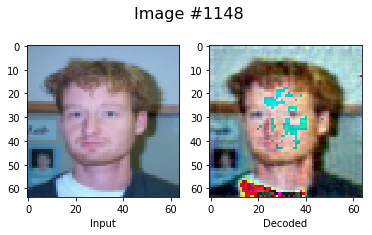

In [72]:
sampleAE(traindataset, aeNet)

## Extract Movie Frames

In [ ]:
# Run only once to extract forrest movie frames
# for i in range(8):
#     extractRunFrames(Paths.movie_run_path(i), Paths.movie_run_snapshots_path(i), 'run-{}'.format(i))

# Encode Forrest To Features

In [74]:
# Load from 'model.pth'
from torch import optim

aeNet = SimpleConvAESmall().cuda()
optimizer = optim.SGD(aeNet.parameters(), lr=0.001, momentum=0.9)
loadModel(os.path.join(Paths.models_path, 'SimpleConvAESmall.pth'), aeNet, optimizer)
aeNet.eval()

SimpleConvAESmall(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder): Sequential(
    (0): ConvTranspose2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
)

In [75]:
generateAllFeatures(aeNet, \
                    [Paths.movie_run_snapshots_path(i) for i in range(8)], \
                    Paths.encoded_features('SimpleConvAE'))

Encoding run 0 frames...
Feature Shape: torch.Size([454, 6144])



Encoding run 1 frames...
Feature Shape: torch.Size([444, 6144])



Encoding run 2 frames...
Feature Shape: torch.Size([441, 6144])



Encoding run 3 frames...
Feature Shape: torch.Size([491, 6144])



Encoding run 4 frames...
Feature Shape: torch.Size([465, 6144])



Encoding run 5 frames...
Feature Shape: torch.Size([442, 6144])



Encoding run 6 frames...
Feature Shape: torch.Size([545, 6144])



Encoding run 7 frames...
Feature Shape: torch.Size([340, 6144])


# Train BOLD Model

In [ ]:
# from torch.utils.data import DataLoader

# [anat_data, mask_data] = loadFMRI(1, 0)
# features = loadFeatures(1, 0, responseLen=anat_data.shape[3])
# features_conv = convolveFeatures(features, 2)
# # plotCompareFeatures(features[:,:10], features_conv[:,:10])
# featureData = FeatureDataset(torch.tensor(features_conv).float(), torch.tensor(anat_data), torch.tensor(mask_data).bool())
# featureLoader = DataLoader(featureData, batch_size=64, shuffle=True, num_workers=1,pin_memory=True)

In [98]:
features.shape

(451, 16384)

In [24]:
# Load encoded features datasets

import random

def loadEncodedRunDatasets(modelName, sub):
    all_run_datasets = []
    for i in range(8):
        [anat_data, mask_data] = loadFMRI(sub, i)
        features = loadFeatures(modelName, i, responseLen=anat_data.shape[3])
        features_conv = convolveFeatures(features, 2)
        featureData = FeatureDataset(torch.tensor(features_conv).float(), torch.tensor(anat_data), torch.tensor(mask_data).bool())
        all_run_datasets.append(featureData)
    return all_run_datasets

def loadPixelRunDataset(sub):
    all_run_datasets = []
    for i in range(8):
        [anat_data, mask_data] = loadFMRI(sub, i)
        features = loadPixelFeatures(Paths.movie_run_snapshots_path(i), i, responseLen=anat_data.shape[3])
        features_conv = convolveFeatures(features, 2)
        featureData = FeatureDataset(torch.tensor(features_conv).float(), torch.tensor(anat_data), torch.tensor(mask_data).bool())
        all_run_datasets.append(featureData)
    return all_run_datasets

# all_run_datasets = loadEncodedRunDatasets('SimpleConvAE', sub=1)
# all_run_datasets = loadPixelRunDataset('SimpleConvAE', sub=1)

In [86]:
all_run_datasets = loadEncodedRunDatasets('SimpleConvAE', sub=2)

FMRI Frames: 451
Movie Run Frames: 451
FMRI Frames: 441
Movie Run Frames: 441
FMRI Frames: 438
Movie Run Frames: 438
FMRI Frames: 488
Movie Run Frames: 488
FMRI Frames: 462
Movie Run Frames: 462
FMRI Frames: 439
Movie Run Frames: 439
FMRI Frames: 542
Movie Run Frames: 542
FMRI Frames: 338
Movie Run Frames: 338


In [11]:
# def experimentModel(modelName):
#     for i in range(1, 4):
#         crossValidationFit(model, datasets):
#         print("Training {} on subject {}...".format(modelName, i))

# experimentModel('SimpleConvAE')

In [87]:
featureNetCrossVal(all_run_datasets, os.path.join(Paths.results_path, 'sub-02','simpleConvAESmallCV.npy'))

/home/wangbrh/BrainProject/utils/evalUtils.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model.forward(torch.tensor(feature).float().cuda()).cpu()


array([[0.97080248, 0.96556329],
       [0.97002499, 0.96511633],
       [0.97163192, 0.95955678],
       [0.97627271, 0.92263461],
       [0.96871891, 0.95919474],
       [0.97219263, 0.95017122],
       [0.97312989, 0.93947655],
       [0.97018094, 0.9694948 ]])

# Results

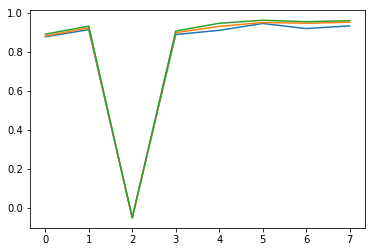

In [96]:
# sub-01
pixelNetCV = np.load(Paths.results_path + "/sub-01/pixelNetCV.npy")
simpleConvAE = np.load(Paths.results_path + "/sub-01/simpleConvAECV.npy")
simpleConvAESmall = np.load(Paths.results_path + "/sub-01/simpleConvAESmallCV.npy")

plt.plot(pixelNetCV[:,1])
plt.plot(simpleConvAE[:,1])
plt.plot(simpleConvAESmall[:,1])

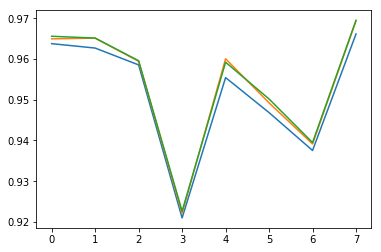

In [97]:
# sub-02
pixelNetCV = np.load(Paths.results_path + "/sub-02/pixelNetCV.npy")
simpleConvAE = np.load(Paths.results_path + "/sub-02/simpleConvAECV.npy")
simpleConvAESmall = np.load(Paths.results_path + "/sub-02/simpleConvAESmallCV.npy")

plt.plot(pixelNetCV[:,1])
plt.plot(simpleConvAE[:,1])
plt.plot(simpleConvAESmall[:,1])

In [ ]:
# sub-03
pixelNetCV = np.load(Paths.results_path + "/sub-03/pixelNetCV.npy")
simpleConvAE = np.load(Paths.results_path + "/sub-03/simpleConvAECV.npy")
simpleConvAESmall = np.load(Paths.results_path + "/sub-03/simpleConvAESmallCV.npy")

plt.plot(pixelNetCV[:,1])
plt.plot(simpleConvAE[:,1])
plt.plot(simpleConvAESmall[:,1])
plt.legend(['pixel', 'AE', 'AESmall'])
plt.show()

In [7]:
for i in range(8):
  train_runs_indices = [j for j in range(8)]
  test_run = train_runs_indices.pop(i)
  print(test_run)
  print(train_runs_indices)

0
[1, 2, 3, 4, 5, 6, 7]
1
[0, 2, 3, 4, 5, 6, 7]
2
[0, 1, 3, 4, 5, 6, 7]
3
[0, 1, 2, 4, 5, 6, 7]
4
[0, 1, 2, 3, 5, 6, 7]
5
[0, 1, 2, 3, 4, 6, 7]
6
[0, 1, 2, 3, 4, 5, 7]
7
[0, 1, 2, 3, 4, 5, 6]
